In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\SUN
[nltk_data]     RISE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv("spam.csv")

In [3]:
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:


# Inspect the column names in your DataFrame
print(data.columns)


Index(['Category', 'Message'], dtype='object')


In [5]:


# Initializing the Porter Stemmer for stemming
stemmer = PorterStemmer()

# Function to preprocess an email
def preprocess_email(email_text):
    # Remove HTML tags (if any)
    email_text = re.sub(r'<[^>]*>', ' ', email_text)
    
    # Convert to lowercase
    email_text = email_text.lower()
    
    # Tokenization (split the text into words)
    words = re.split(r'\W', email_text)
    
    # Removing stopwords and perform stemming
    words = [stemmer.stem(word) for word in words if word not in stopwords.words('english')]
    
    # Joining the words back into a string
    email_text = ' '.join(words)
    
    return email_text




In [6]:

data['preprocessed_message'] = data['Message'].apply(preprocess_email)

print(data[['Message', 'preprocessed_message']].head())


                                             Message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                preprocessed_message  
0  go jurong point  crazi   avail bugi n great wo...  
1                        ok lar    joke wif u oni     
2  free entri 2 wkli comp win fa cup final tkt 21...  
3          u dun say earli hor    u c alreadi say     
4              nah think goe usf  live around though  


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [8]:
X = data['preprocessed_message']  # Feature (preprocessed text)
y = data['Category']  # Target (spam or not spam)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the number of features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [11]:
y_train = y_train.map({'spam': 1, 'ham': 0})
y_test = y_test.map({'spam': 1, 'ham': 0})

In [12]:
nb_classifier = MultinomialNB()

In [13]:
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [14]:
y_pred = nb_classifier.predict(X_test_tfidf)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


In [16]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.99      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [17]:
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion)

Confusion Matrix:
 [[965   1]
 [ 31 118]]


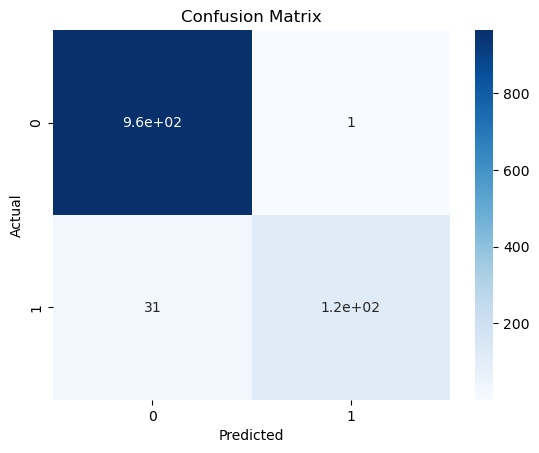

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
sns.heatmap(confusion, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


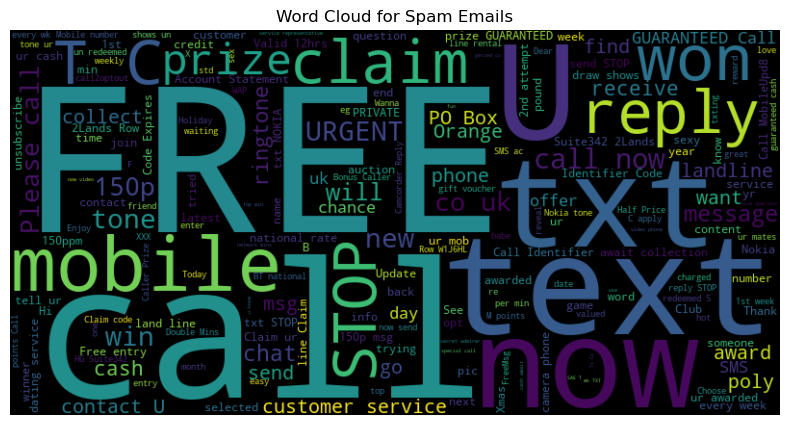

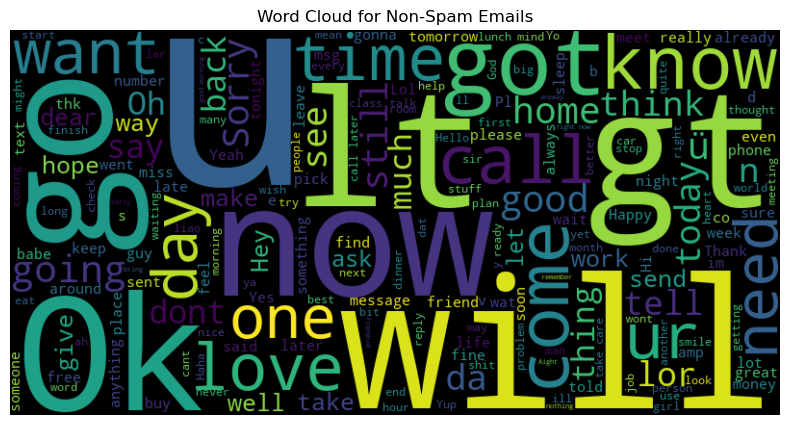

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#  word cloud for spam emails
spam_wordcloud = WordCloud(width=800, height=400).generate(' '.join(data[data['Category'] == 'spam']['Message']))
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Emails')
plt.axis('off')
plt.show()

#  word cloud for non-spam emails
ham_wordcloud = WordCloud(width=800, height=400).generate(' '.join(data[data['Category'] == 'ham']['Message']))
plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Non-Spam Emails')
plt.axis('off')
plt.show()


In [20]:
!pip install wordcloud


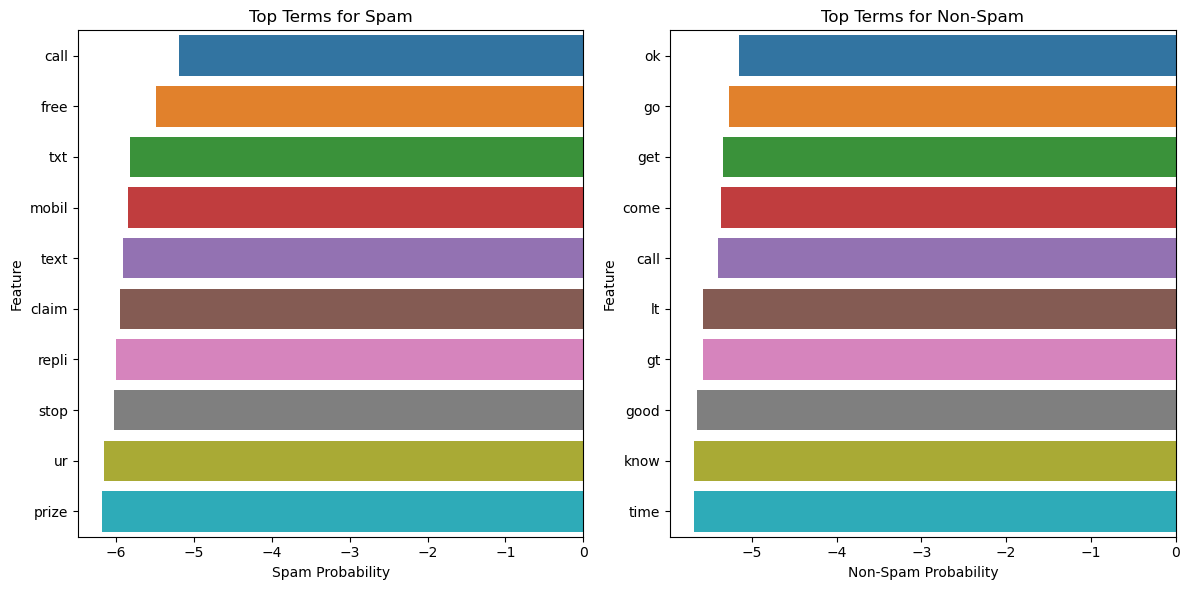

In [21]:
#  feature probabilities for spam and non-spam
spam_feature_prob = nb_classifier.feature_log_prob_[1]
ham_feature_prob = nb_classifier.feature_log_prob_[0]

#  feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to associate words with their probabilities
feature_prob_df = pd.DataFrame({'Feature': feature_names, 'Spam Probability': spam_feature_prob, 'Non-Spam Probability': ham_feature_prob})

#  probability to find important terms
top_spam_terms = feature_prob_df.sort_values(by='Spam Probability', ascending=False).head(10)
top_ham_terms = feature_prob_df.sort_values(by='Non-Spam Probability', ascending=False).head(10)

# Visualing top terms for spam and non-spam
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Spam Probability', y='Feature', data=top_spam_terms)
plt.title('Top Terms for Spam')

plt.subplot(1, 2, 2)
sns.barplot(x='Non-Spam Probability', y='Feature', data=top_ham_terms)
plt.title('Top Terms for Non-Spam')

plt.tight_layout()
plt.show()
